In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1]:
# HeedongEDA, HeedongModeling 파일의 내용이 바뀔때마다 이거 실행해서 갱신 시키면 됨
import HeedongEDA as hd
import HeedongModeling as hm
import imp
imp.reload(hd)
imp.reload(hm)

<module 'HeedongModeling' from '/Users/eunjin/Documents/GitHub/hackerton/HeedongModeling.py'>

In [4]:
marketing = pd.read_csv('bank-additional-full.csv', delimiter=';')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
# 변수들 중 고유값이 한개인 컬럼들을 제거한다.
marketing = hd.removeunique(marketing)

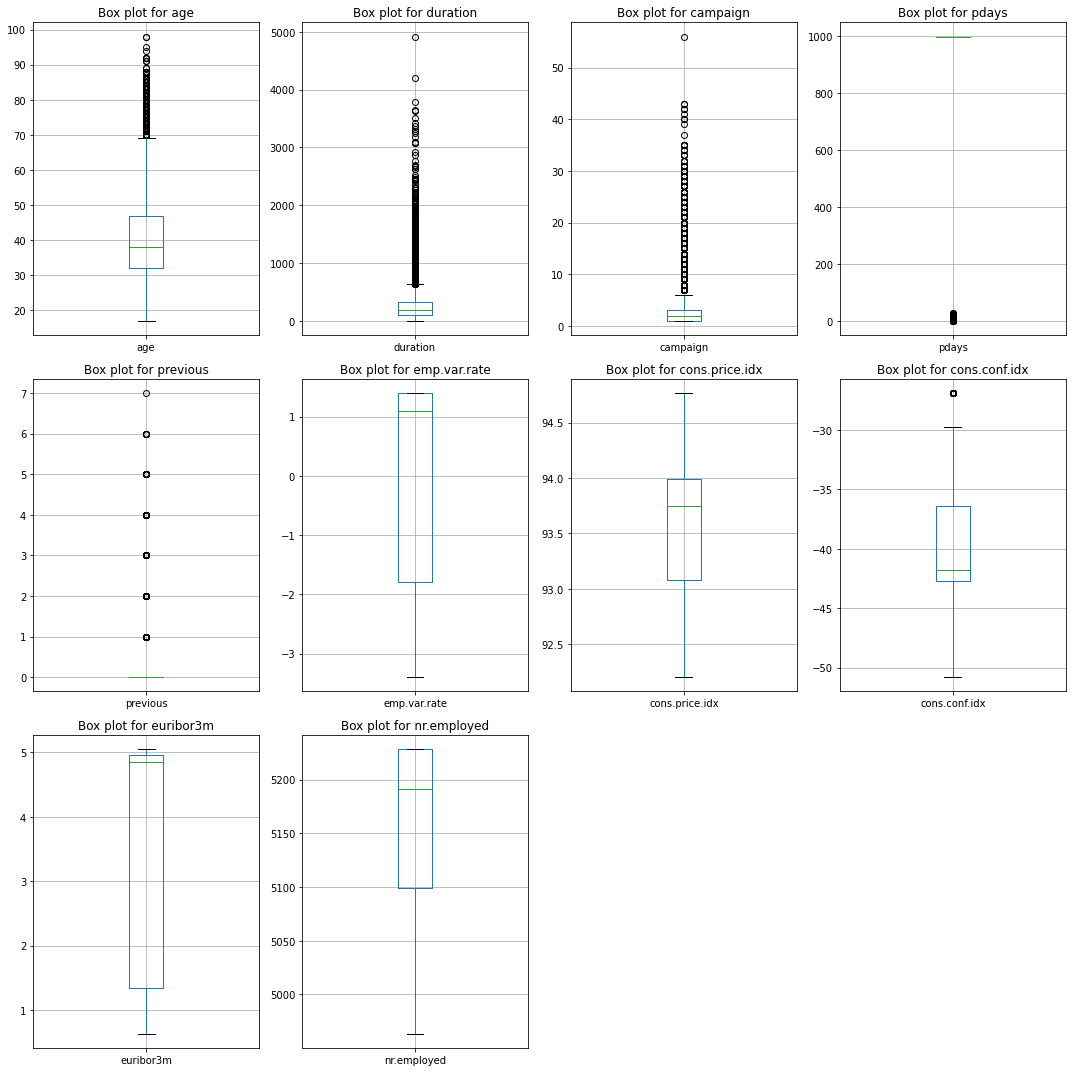

In [9]:
# 숫자형 변수들의 이상치 분포를 출력한다.
hd.plotoutliers(marketing)

In [10]:
# 데이터의 숫자형 변수들을 윈저라이징 한다
marketing = hd.mywinsorizer(marketing)

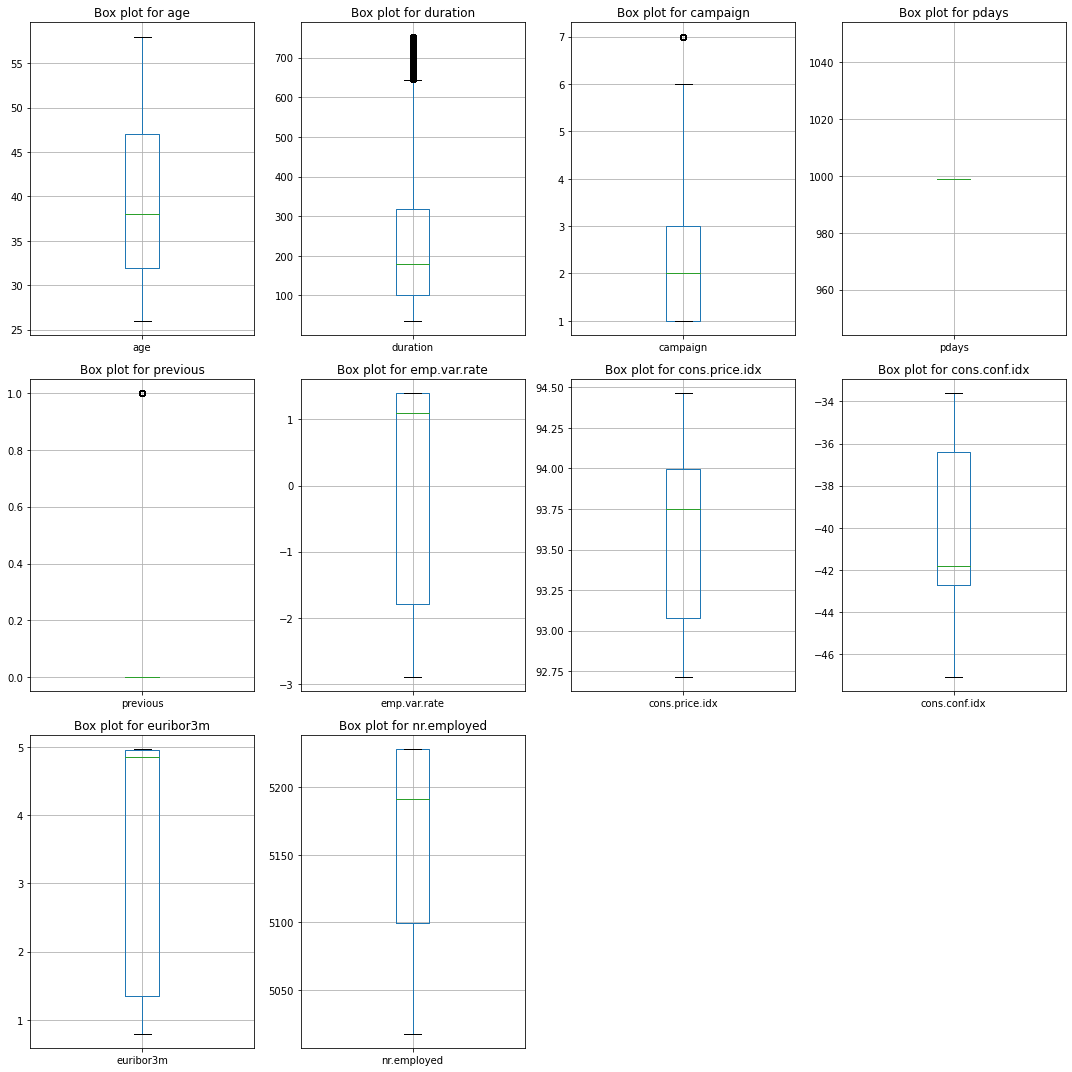

In [11]:
# 숫자형 변수들의 이상치 분포를 출력한다.
hd.plotoutliers(marketing)

In [12]:
# 숫자형 변수들을 따로 추출
num, num_col = hd.getvarcol(marketing, select = 0)
# 범주형 변수들을 따로 추출
obj, obj_col = hd.getvarcol(marketing, select = 1)
# 타겟 변수를 매핑하고 타겟 컬럼을 추출
marketing['y'] = marketing['y'].map(
    {
        'no' : 0,
        'yes' : 1
    }
)
target = marketing['y']

In [13]:
# 바이너리 인코더 객체 생성
from category_encoders import BinaryEncoder
encoder = BinaryEncoder(cols = obj_col)

# 인코딩 수행
marketing_object_encoded = encoder.fit_transform(obj)

# 인코딩된 데이터 확인
print(marketing_object_encoded.head())

   job_0  job_1  job_2  job_3  marital_0  marital_1  marital_2  education_0  \
0      0      0      0      1          0          0          1            0   
1      0      0      1      0          0          0          1            0   
2      0      0      1      0          0          0          1            0   
3      0      0      1      1          0          0          1            0   
4      0      0      1      0          0          0          1            0   

   education_1  education_2  ...  month_1  month_2  month_3  day_of_week_0  \
0            0            0  ...        0        0        1              0   
1            0            1  ...        0        0        1              0   
2            0            1  ...        0        0        1              0   
3            0            1  ...        0        0        1              0   
4            0            1  ...        0        0        1              0   

   day_of_week_1  day_of_week_2  poutcome_0  poutcome_1 

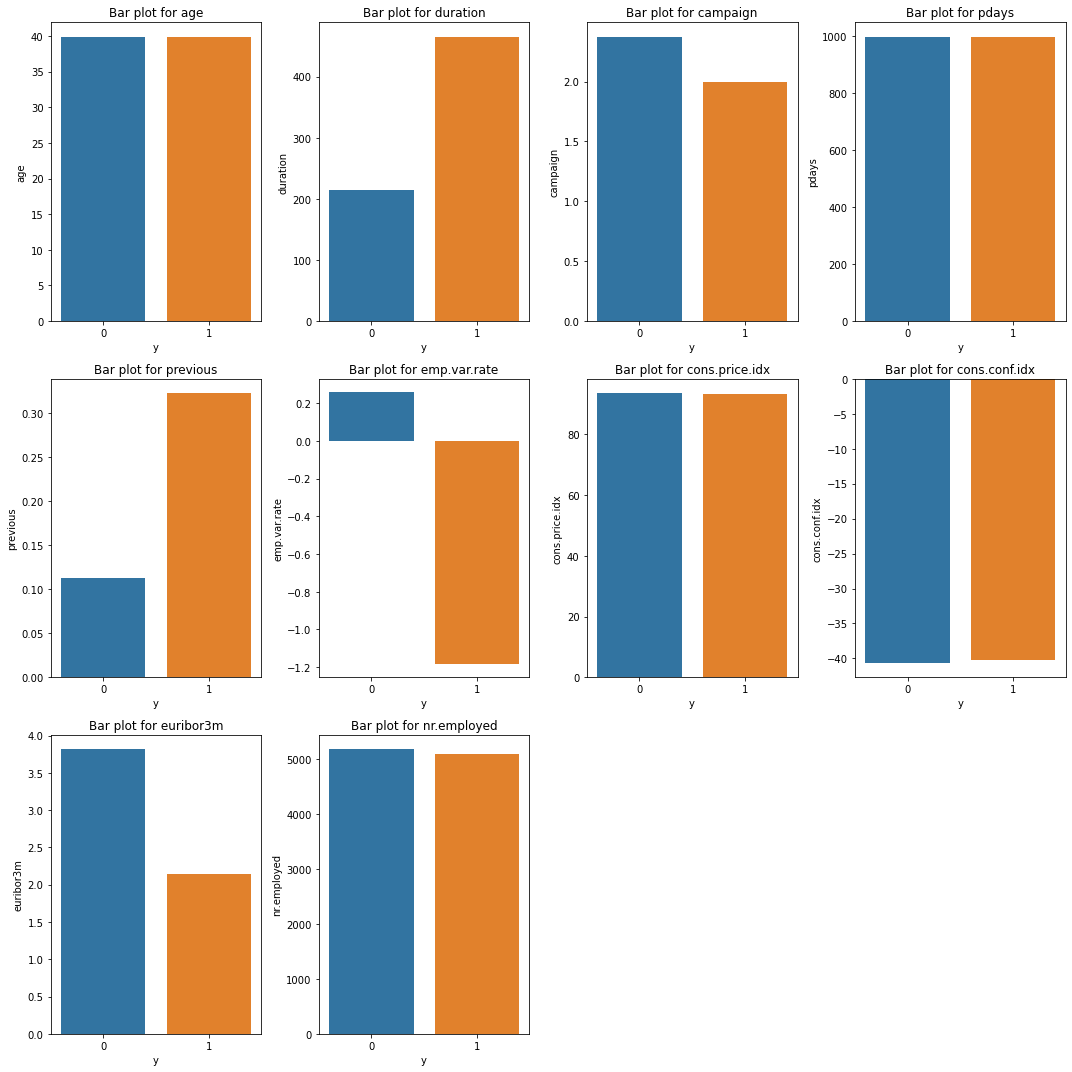

In [14]:
# 각 숫자형 변수들의 분포를 출력
hd.num_plot(marketing)

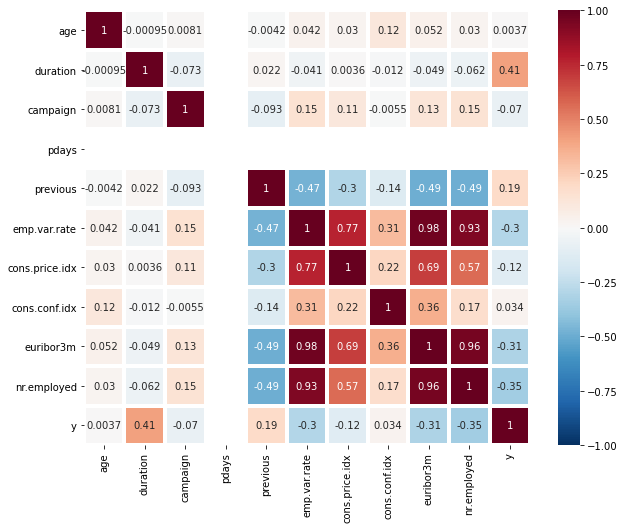

In [15]:
# 각 숫자형 변수들의 피어슨 상관 분포를 히트맵으로 출력
hd.plot_cor(marketing)

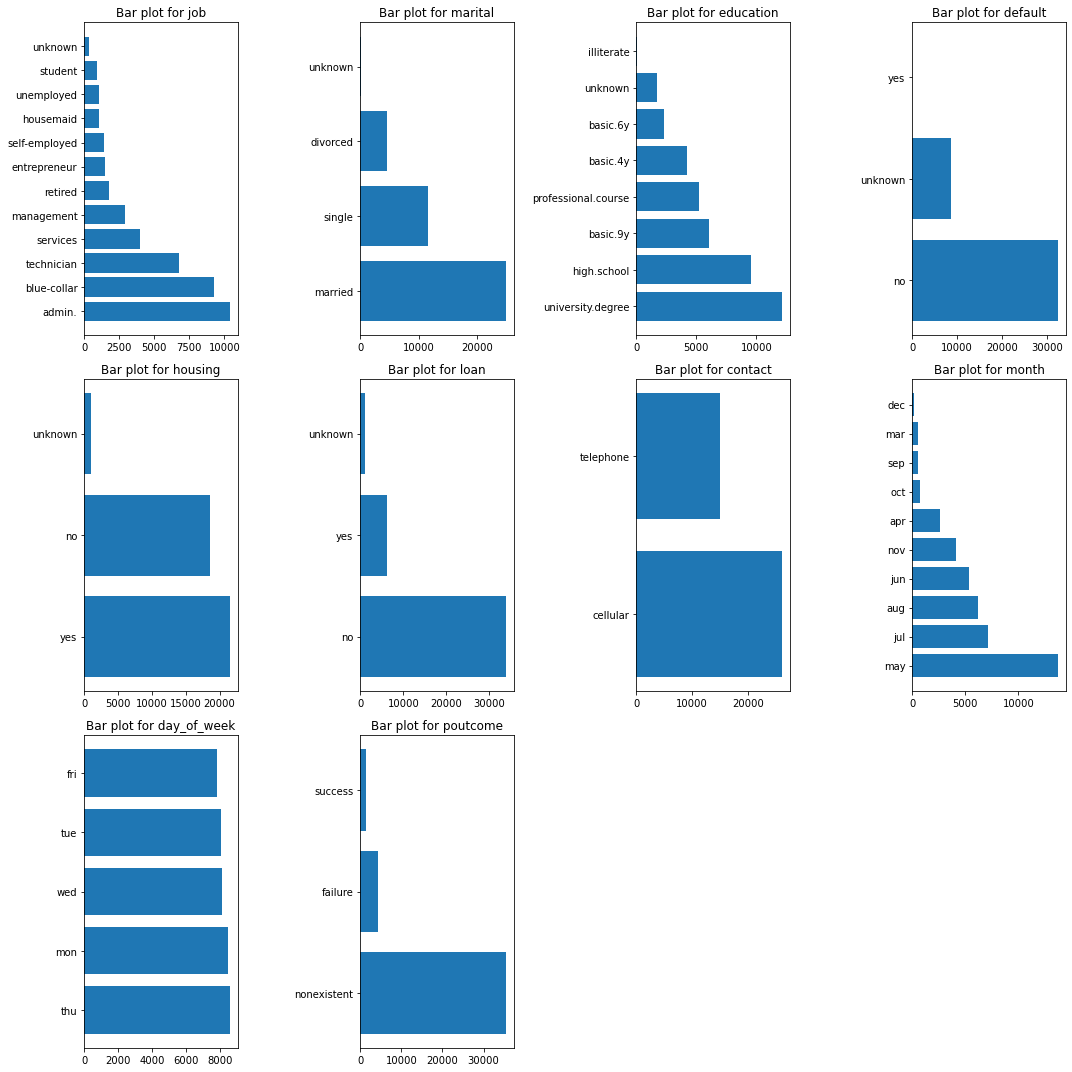

In [16]:
## 범주형 변수들을 시각화
hd.obj_plot(marketing)

In [17]:
# 바이너리 인코더로 인코딩을 하고 인코딩된 컬럼과 인코딩 정보가 담긴 딕셔너리를 결과값을 받아온다
obj_encoded, obj_encoded_col, encoded_dict = hd.encoding(marketing)

In [18]:
# 데이터셋 클래스 분포 확인
from collections import Counter
counter = Counter(target)
print(f'타겟의 데이터 분포는 다음과 같음 - {counter}')

# 인코딩된 범주형 변수와 숫자형 변수 데이터를 통합
x = pd.concat([obj_encoded, num], axis=1)

타겟의 데이터 분포는 다음과 같음 - Counter({0: 36548, 1: 4640})


In [19]:
# 리샘플링. 0이 언더샘플링, 1이 오버샘플링. 그 이외값이면 안한다.
x_sm, y_sm = hd.resampler(x, target, 0)

Resampled Dataset Shape Counter({0: 4640, 1: 4640})


In [20]:
# 불필요한 컬럼인 pdays를 날린다
x_sm.drop('pdays', axis=1, inplace=True)
num_col_dummy = num_col
num_col.remove('pdays')

In [21]:
# 데이터 스케일링, 0이 Minmax, 1이 Standard, 2가 Robust, 그 이외값이면 안함.
x_num = hd.myscaler(x_sm[num_col],0)

Scaled (0.00, 1.00) (0.43, 0.38)


In [22]:
# PCA 변환한 후 숫자형 변수들의 VIF 지수를 확인해본다.
hd.check_vif(x_num)

         features  VIF Factor
0             age    2.820858
1        duration    2.545552
2        campaign    1.643409
3        previous    1.698279
4    emp.var.rate   99.328312
5  cons.price.idx   11.660114
6   cons.conf.idx    3.138296
7       euribor3m   69.241619
8     nr.employed   44.419630


In [23]:
vif_high_columns = ['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
x_num_pca = hd.doPCA(x_num, vif_high_columns, ['Macroeconomics'], 1)

VIF지수가 높은 4개의 피처를 1개의 피처로 PCA 변환했을 때 새롭게 나온 피처가 전체의 변동성을 [86.47622578]%만큼 설명해준다


In [24]:
# 숫자형 변수들의 VIF 지수를 확인해본다.
hd.check_vif(x_num_pca)

         features  VIF Factor
0             age    2.390642
1        duration    1.954199
2        campaign    1.480739
3        previous    1.641922
4   cons.conf.idx    2.450607
5  Macroeconomics    1.363239


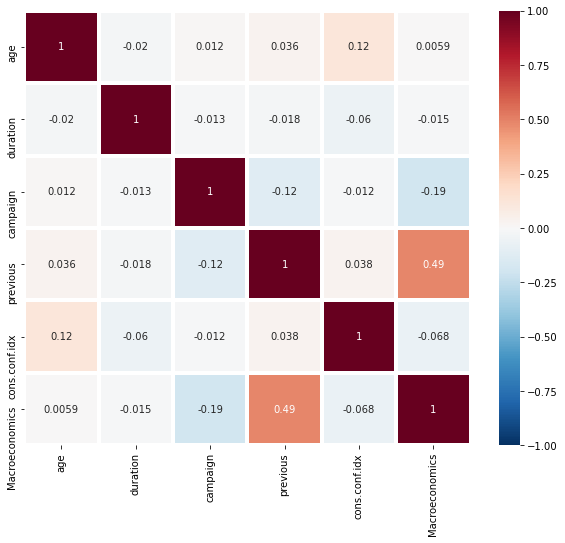

In [25]:
# PCA 변환한 후 숫자형 변수들의 피어슨 상관 분포를 히트맵으로 출력
hd.plot_cor(x_num_pca)

In [26]:
# PCA를 하지않고 전처리를 완료한 데이터와 PCA 작업을 포함하여 전처리를 완료한 데이터
x_total = pd.concat([x_sm[obj_encoded_col], x_num], axis=1)
x_total_pca = pd.concat([x_sm[obj_encoded_col], x_num_pca], axis=1)

In [27]:
x_total_pca

,job_0,job_1,job_2,job_3,marital_0,marital_1,marital_2,education_0,education_1,education_2,...,day_of_week_1,day_of_week_2,poutcome_0,poutcome_1,age,duration,campaign,previous,cons.conf.idx,Macroeconomics
0,0,1,0,1,0,0,1,0,1,0,...,1,0,1,0,0.75000,0.394700,0.166667,1.0,0.377778,-0.296180
1,0,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0.00000,0.312413,0.000000,0.0,0.792593,-0.671477
2,0,0,1,1,0,1,0,0,1,1,...,0,1,0,1,0.59375,0.071130,0.333333,0.0,0.792593,-0.671035
3,0,0,1,1,0,0,1,0,1,1,...,0,0,0,1,0.62500,0.246862,0.000000,0.0,1.000000,0.900814
4,0,0,1,1,0,0,1,0,1,1,...,0,1,1,1,0.37500,0.103208,0.333333,1.0,1.000000,1.052159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,0,1,1,0,0,0,1,0,1,1,...,0,0,1,1,1.00000,0.239888,0.000000,1.0,0.000000,0.498802
9276,0,1,1,0,0,0,1,0,1,1,...,0,0,1,1,1.00000,0.623431,0.166667,1.0,0.000000,0.498802
9277,0,0,1,1,0,0,1,0,1,1,...,0,1,0,1,0.34375,0.341702,0.000000,0.0,0.000000,0.499244
9278,0,1,1,0,0,0,1,0,1,0,...,0,1,0,1,1.00000,0.415621,0.000000,0.0,0.000000,0.499244


In [28]:
#### PCA 안한거
# 학습 데이터와 테스트 데이터를 분할한다.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_total, y_sm, train_size=0.8, random_state=1, stratify=y_sm)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# 학습 데이터와 테스트 데이터를 나눈 후 인덱스를 재정렬한다.
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


#### PCA 한거
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_total_pca, y_sm, train_size=0.8, random_state=1, stratify=y_sm)
print(x_train_pca.shape, x_test_pca.shape, y_train_pca.shape, y_test_pca.shape)
# 학습 데이터와 테스트 데이터를 나눈 후 인덱스를 재정렬한다.
x_train_pca.reset_index(drop=True, inplace=True)
x_test_pca.reset_index(drop=True, inplace=True)
y_train_pca.reset_index(drop=True, inplace=True)
y_test_pca.reset_index(drop=True, inplace=True)

(7424, 37) (1856, 37) (7424,) (1856,)
(7424, 34) (1856, 34) (7424,) (1856,)


In [29]:
# PCA의 성능을 검증해보자

# PCA 적용 안 시킨거
hd.pca_check(x_train, x_test, y_train, y_test, "precision", 3, 0)
# PCA 적용 시킨거
hd.pca_check(x_train_pca, x_test_pca, y_train_pca, y_test_pca, "precision", 3, 1)

CV=3 인 경우의 개별 Fold 세트별 precision 교차검증 :  [0.8601 0.8481 0.8582]
데이터 셋 평균 precision : 0.8555
precision 예측 성능 : 0.839
CV=3 인경우의 PCA 변환된 개별 Fold 세트별 precision 교차검증 :  [0.8565 0.8564 0.8534]
PCA 변환 데이터 셋 평균 precision : 0.8554
precision 예측 성능 : 0.8402


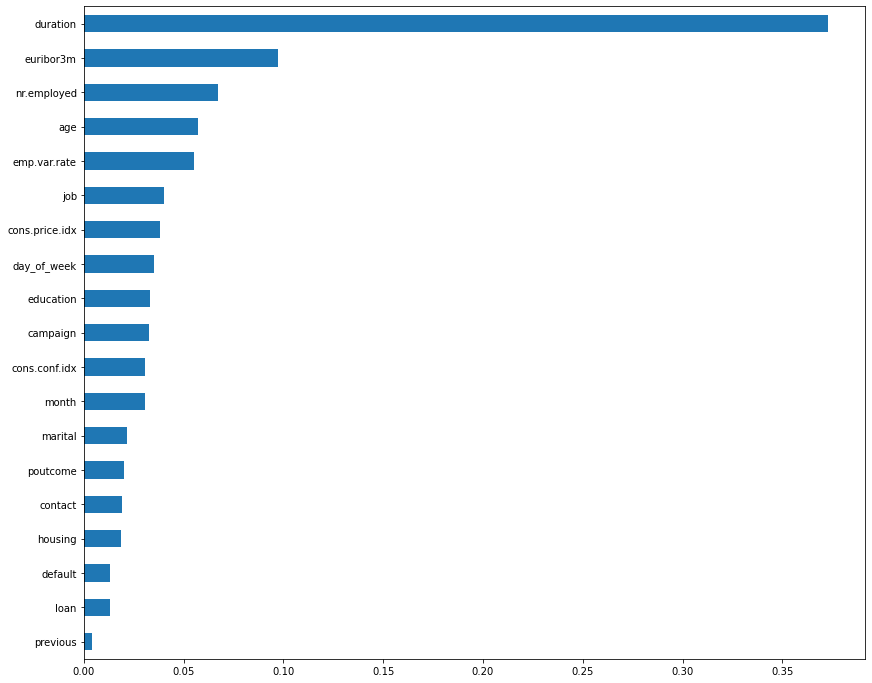

In [30]:
# 각 피쳐들의 중요도를 구한다(PCA 안한거)
hd.get_importance(x_train, y_train)

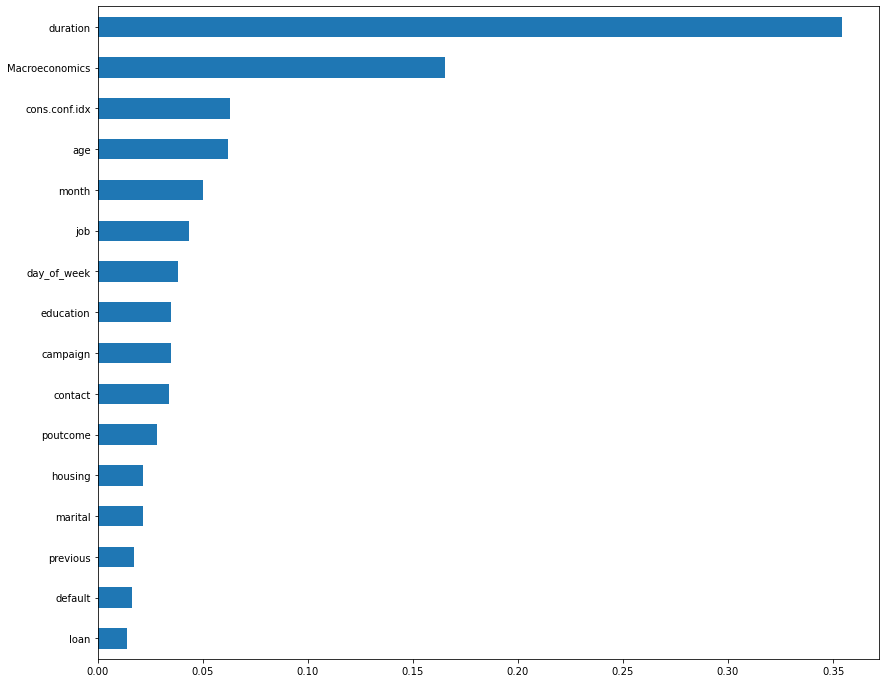

In [31]:
# 각 피쳐들의 중요도를 구한다(PCA 한거)
hd.get_importance(x_train_pca,y_train_pca)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'max_depth': 40, 'n_estimators': 1000}
최적의 하이퍼 파라미터 : {'max_depth': 40, 'n_estimators': 1000}
교차 검증 정확도 : [0.8909 0.8896 0.8882 0.8929 0.8922], 평균 정확도 : 0.8908
교차 검증 정밀도 : [0.8607 0.8577 0.8514 0.8668 0.8601], 평균 정밀도 : 0.8594
교차 검증 재현율 : [0.9326 0.934  0.9408 0.9287 0.9367], 평균 재현율 : 0.9345
교차 검증 f1 스코어 : [0.8952 0.8942 0.8939 0.8967 0.8968], 평균 f1 스코어 : 0.8953
교차 검증 roc_auc : [0.9374 0.9389 0.945  0.9483 0.9436], 평균 roc_auc : 0.9426


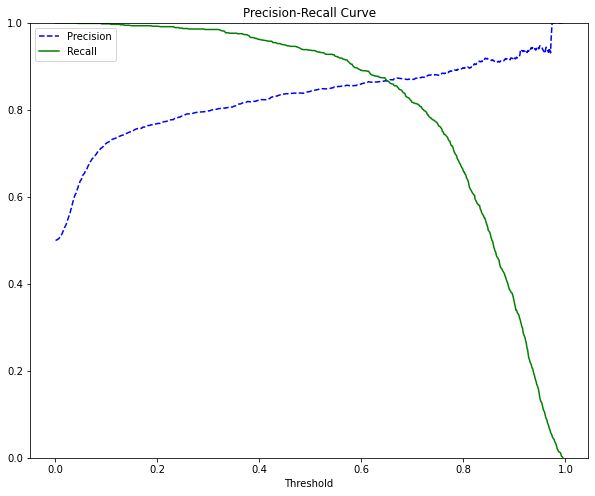

최적의 Threshold 값 : 0.651
혼돈행렬 : [[804 124]
 [124 804]]
정확도 : 0.8664
정밀도 : 0.8664
재현율 : 0.8664
roc_auc 스코어 : 0.8664
f1 스코어 : 0.8664


In [33]:
## 랜덤 포레스트 PCA 안 한거
mod = 1
best_grid1 = hm.param_tuning(x_train, y_train, model_select=mod, scoring="precision")
hm.model_performance(x_train, x_test, y_train, y_test, model_select=mod, best_grid=best_grid1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'max_depth': 40, 'n_estimators': 200}
최적의 하이퍼 파라미터 : {'max_depth': 40, 'n_estimators': 200}
교차 검증 정확도 : [0.864  0.8828 0.8801 0.8788 0.8956], 평균 정확도 : 0.8803
교차 검증 정밀도 : [0.8309 0.8524 0.8518 0.848  0.8664], 평균 정밀도 : 0.8499
교차 검증 재현율 : [0.9137 0.9259 0.9206 0.9233 0.9353], 평균 재현율 : 0.9238
교차 검증 f1 스코어 : [0.8703 0.8876 0.8849 0.884  0.8995], 평균 f1 스코어 : 0.8853
교차 검증 roc_auc : [0.9229 0.9347 0.9386 0.9389 0.9459], 평균 roc_auc : 0.9362


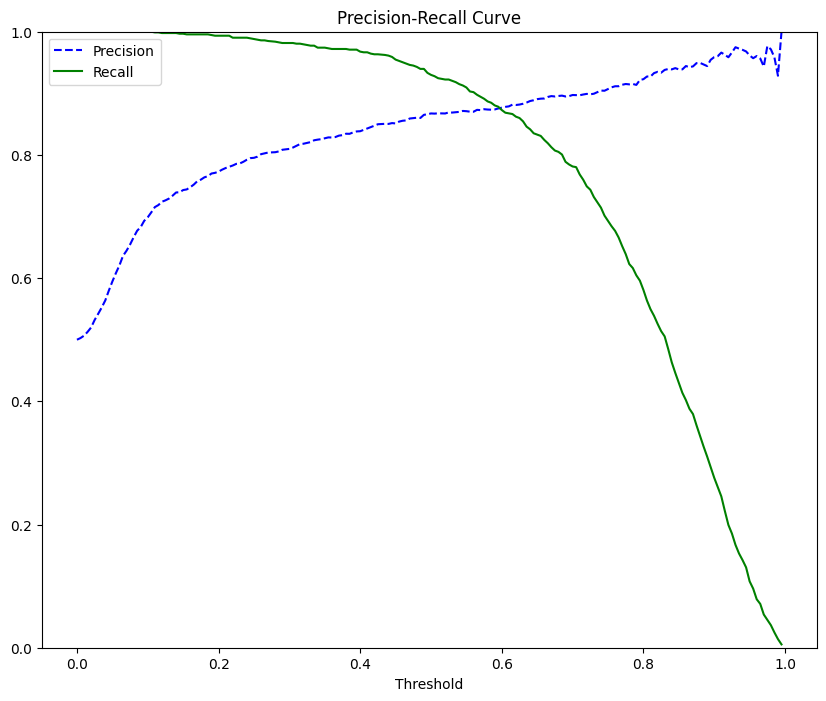

최적의 Threshold 값 : 0.595
혼돈행렬 : [[812 116]
 [113 815]]
정확도 : 0.8766
정밀도 : 0.8754
재현율 : 0.8782
roc_auc 스코어 : 0.8766
f1 스코어 : 0.8768


In [ ]:
## 랜덤 포레스트 PCA 한거
mod = 1
best_grid1 = hm.param_tuning(x_train_pca, y_train_pca, model_select=mod, scoring="precision")
hm.model_performance(x_train_pca, x_test_pca, y_train_pca, y_test_pca, model_select=mod, best_grid=best_grid1)

In [ ]:
## 의사 결정 나무 PCA 안 한거
mod = 2
best_grid2 = hm.param_tuning(x_train, y_train, model_select=mod, scoring="precision")
hm.model_performance(x_train, x_test, y_train, y_test, model_select=mod, best_grid=best_grid2)

In [ ]:
## 의사 결정 나무 PCA 한거
mod = 2
best_grid2 = hm.param_tuning(x_train_pca, y_train_pca, model_select=mod, scoring="precision")
hm.model_performance(x_train_pca, x_test_pca, y_train_pca, y_test_pca, model_select=mod, best_grid=best_grid2)

In [ ]:
## 로지스틱 회귀 PCA 안 한거
mod = 3
best_grid3 = hm.param_tuning(x_train, y_train, model_select=mod, scoring="precision")
hm.model_performance(x_train, x_test, y_train, y_test, model_select=mod, best_grid=best_grid3)

In [ ]:
## 로지스틱 회귀 PCA 한거
mod = 3
best_grid3 = hm.param_tuning(x_train_pca, y_train_pca, model_select=mod, scoring="precision")
hm.model_performance(x_train_pca, x_test_pca, y_train_pca, y_test_pca, model_select=mod, best_grid=best_grid3)

In [ ]:
## ADABoost PCA 안 한거
mod = 4
best_grid4 = hm.param_tuning(x_train, y_train, model_select=mod, scoring="precision")
hm.model_performance(x_train, x_test, y_train, y_test, model_select=mod, best_grid=best_grid4)

In [ ]:
## ADABoost PCA 한거
mod = 4
best_grid4 = hm.param_tuning(x_train_pca, y_train_pca, model_select=mod, scoring="precision")
hm.model_performance(x_train_pca, x_test_pca, y_train_pca, y_test_pca, model_select=mod, best_grid=best_grid4)

In [ ]:
## XGBoost PCA 안 한거
mod = 5
best_grid5 = hm.param_tuning(x_train, y_train, model_select=mod, scoring="precision")
hm.model_performance(x_train, x_test, y_train, y_test, model_select=mod, best_grid=best_grid5)

In [ ]:
## XGBoost PCA 한거
mod = 5
best_grid5 = hm.param_tuning(x_train_pca, y_train_pca, model_select=mod, scoring="precision")
hm.model_performance(x_train_pca, x_test_pca, y_train_pca, y_test_pca, model_select=mod, best_grid=best_grid5)